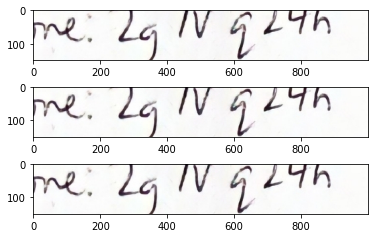

In [20]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('C:/Users/Trixcie/Downloads/HenryFong_Ceftriaxone_1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=[0.5,0.5])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(3):
	# define subplot
	pyplot.subplot(310 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()